# L14: Convolutional Neural Networks
[1. Setup](#1.-Setup)\
[2. Convolutional Layers](#2.-Convolutional-Layers)\
[3. Pooling Layers](#3.-Pooling-Layers)\
[4. CNN Architectures](#4.-CNN-Architectures)\
[5. Implementing a ResNet-34 CNN Using Keras](#5.-Implementing-a-ResNet-34-CNN-Using-Keras)\
[6. Using Pretrained Models from Keras](#6.-Using-Pretrained-Models-from-Keras)

# 1. Setup

Install `TensorFlow` (only need to run once)

In [1]:
# pip install tensorflow

Import `TensorFlow`

In [2]:
import tensorflow as tf

Define the default font sizes to make the figures prettier

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Create the `images/cnn` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "cnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 2. Convolutional Layers
## Implementing Convolutional Layers With Keras

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:

In [5]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [6]:
images.shape

TensorShape([2, 70, 120, 3])

In [7]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [8]:
fmaps.shape

TensorShape([2, 64, 114, 32])

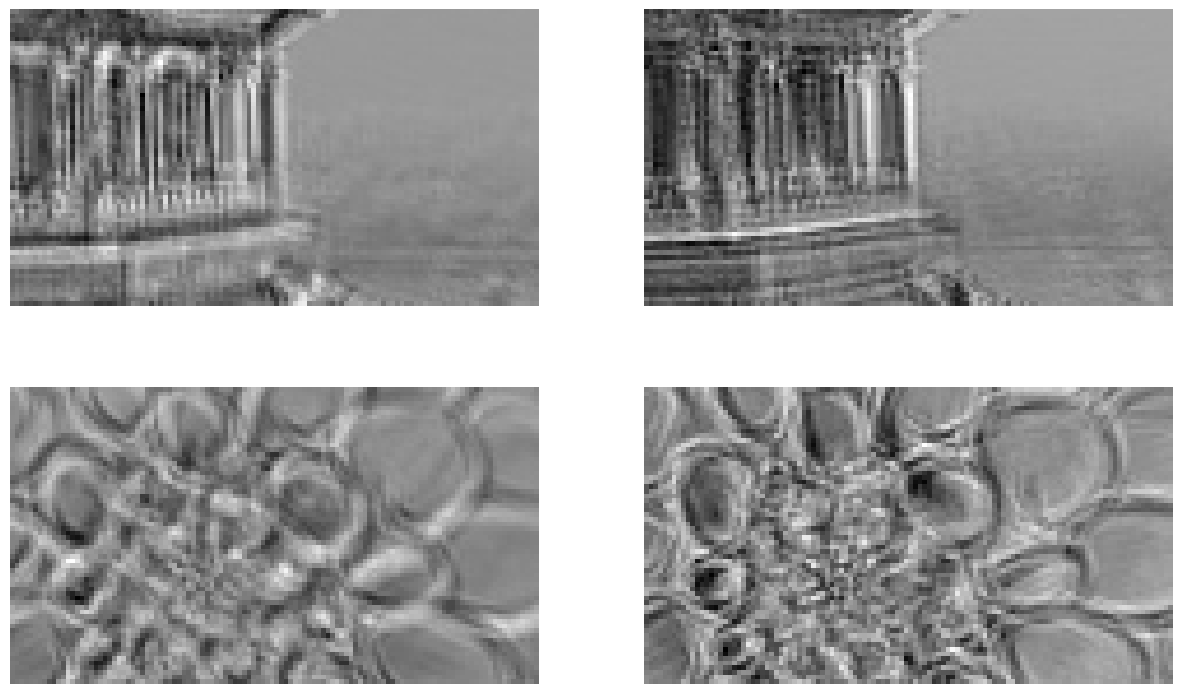

In [9]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding:

In [10]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [11]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [12]:
# extra code – shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [13]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Let's now look at the weights:

In [14]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [15]:
biases.shape

(32,)

In [16]:
# extra code – shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter (just like in Figure 14–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

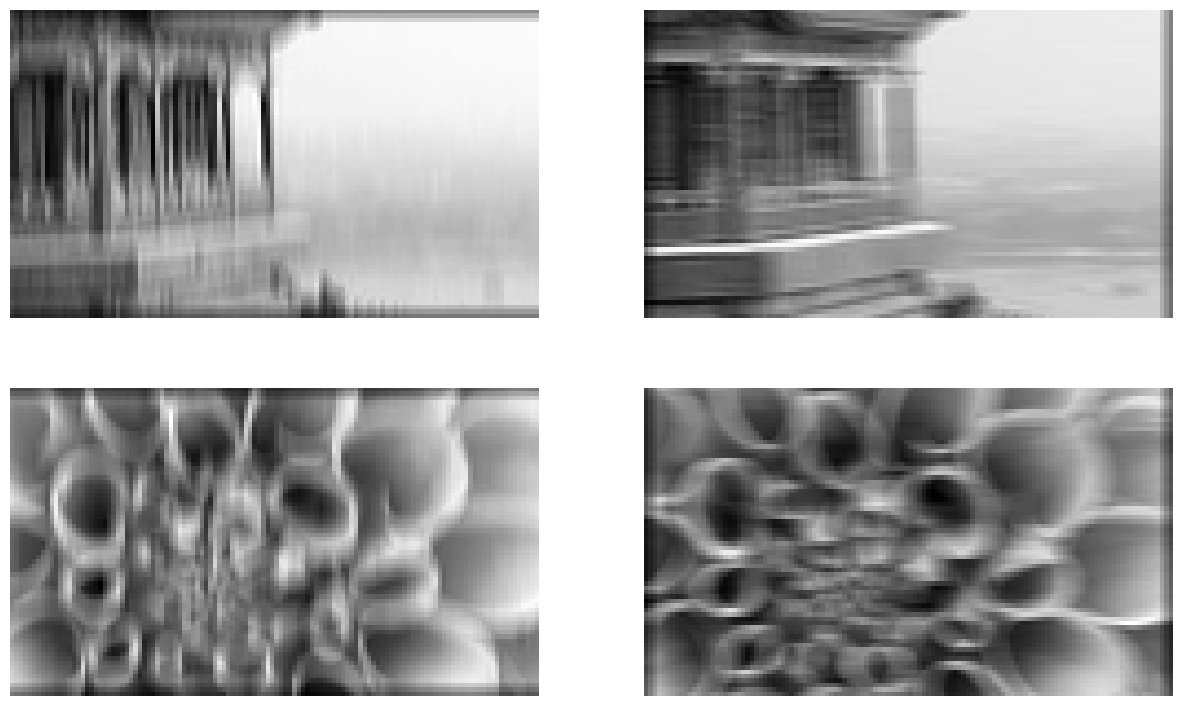

In [17]:
# extra code – shows how to manually create two filters to get images similar
#              to those in Figure 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

# 3. Pooling Layers
## Implementing Pooling Layers With Keras

**Max pooling**

In [18]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [19]:
output = max_pool(images)

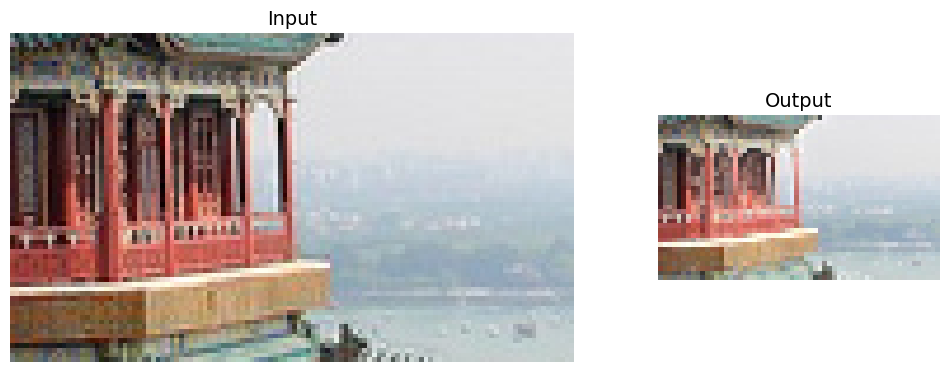

In [20]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Depth-wise pooling**

In [21]:
# extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [22]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [23]:
# extra code – shows that this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

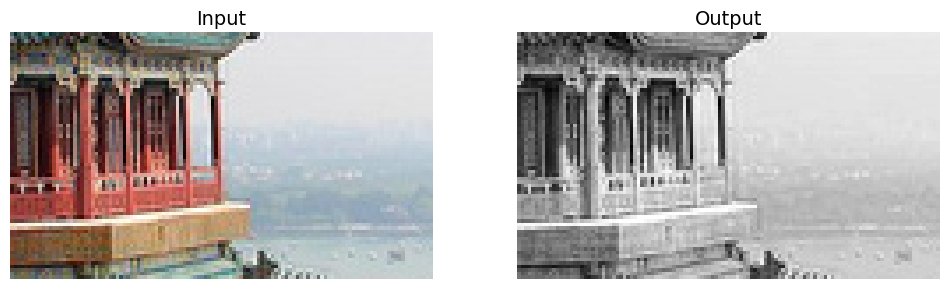

In [24]:
# extra code – computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

**Global Average Pooling**

In [25]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

The following layer is equivalent:

In [26]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [27]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.26011038, 0.10849128]], dtype=float32)>

# 4. CNN Architectures

**Tackling Fashion MNIST With a CNN**

In [28]:
# extra code – loads the mnist dataset, add the channels axis to the inputs,
#              scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [29]:
from functools import partial

tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [30]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # pretend we have new images
y_pred = model.predict(X_new)


Epoch 1/10


1719/1719 [==============================] - 291s 166ms/step - loss: 0.7445 - accuracy: 0.7357 - val_loss: 0.3830 - val_accuracy: 0.8600
Epoch 2/10
1719/1719 [==============================] - 243s 141ms/step - loss: 0.4187 - accuracy: 0.8588 - val_loss: 0.3240 - val_accuracy: 0.8852
Epoch 3/10
1719/1719 [==============================] - 243s 141ms/step - loss: 0.3556 - accuracy: 0.8799 - val_loss: 0.3008 - val_accuracy: 0.8896
Epoch 4/10
1719/1719 [==============================] - 242s 141ms/step - loss: 0.3148 - accuracy: 0.8907 - val_loss: 0.2595 - val_accuracy: 0.9032
Epoch 5/10
1719/1719 [==============================] - 242s 141ms/step - loss: 0.2923 - accuracy: 0.9022 - val_loss: 0.2786 - val_accuracy: 0.8976
Epoch 6/10
1719/1719 [==============================] - 241s 140ms/step - loss: 0.2706 - accuracy: 0.9071 - val_loss: 0.2620 - val_accuracy: 0.9106
Epoch 7/10
1719/1719 [==============================] - 231s 134ms/step - loss: 0.2547 - accuracy: 0.9135 - v

## LeNet-5

The famous LeNet-5 architecture had the following layers:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –

There were a few tweaks here and there, which don't really matter much anymore, but in case you are interested, here they are:

* MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.
* Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the [original paper](https://homl.info/lenet5) for details.
* The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

# 5. Implementing a ResNet-34 CNN Using Keras

**Step 1: create a `ResidualUnit` layer**

In [31]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

**Step 2: build a ResNet-34 using a `Sequential` model**

In [32]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

It is amazing that in about 40 lines of code, we can build the model that won the ILSVRC 2015 challenge! This demonstrates both the elegance of the ResNet model and the expressiveness of the Keras API. Implementing the other CNN architectures is a bit longer, but not much harder. However, Keras comes with several of these architectures built in, so why not use them instead?

# 6. Using Pretrained Models from Keras

**Step 1: load the ResNet-50 model, pretrained on ImageNet**

In [39]:
model = tf.keras.applications.ResNet50(weights="imagenet")

**Step 2: load and resize images**

In [34]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

**Step 3: preprocess the images**

In [35]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

**Step 4: make predictions**

In [36]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 2s 2s/step


(2, 1000)

In [37]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.72%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.66%
  n11939491 - daisy        17.81%
  n03530642 - honeycomb    12.06%


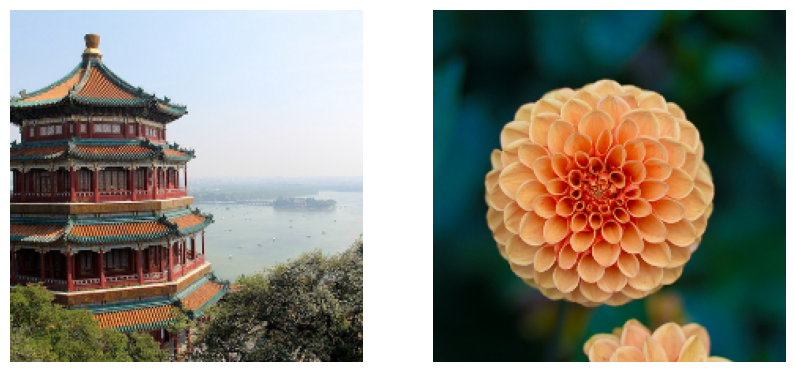

In [38]:
# extra code – displays the cropped and resized images

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()